In [1]:
from datetime import date
from glob import glob
import io
import json
import math
import os
from pathlib import Path
from PIL import Image
import sys
import time

import gspread
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats
from pptx import Presentation
from pptx.util import Inches

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
%matplotlib widget

#### Load excel sheet with metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
## Load Templeton log ##
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
Temp_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe
## Load Zap&zip log ##
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
ZZ_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [6]:
data_dir = Path(r"F:\\")

In [7]:
plotdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\brain_states_analyses\EP metrics'

In [8]:
inj_states = ['psilocybin', 'ketanserin', 'saline']

### Functions

In [9]:
def get_good_bad_chs(bad_ch_str, ch_list):
    if bad_ch_str == 'all':
        bad_chs = ch_list
        good_chs = []
    else:
        badchstr = bad_ch_str.replace(' ','')
        bad_chs = []
        for char in badchstr.split(','):
            if char.isdecimal():
                bad_chs.append(int(char))
        good_chs = np.array([x for x in ch_list if x not in bad_chs])
    return good_chs, bad_chs

In [10]:
def save_fig_to_pptx(fig, prs, slide=None, position=None):
    slide_W = 12; slide_H = 6
    set_dpi = 100

    # Save the Matplotlib figure to an in-memory buffer with tight bounding box
    image_buffer = io.BytesIO()
    fig.savefig(image_buffer, format='png', facecolor='white', dpi=set_dpi, bbox_inches='tight')#,pad_inches=0.1)
    image_buffer.seek(0)
    
    # Get figure size
    image = Image.open(image_buffer)
    width, height = image.size
    fig_W_inches = width / set_dpi
    fig_H_inches = height / set_dpi
    
    margin_pad = 0.1
    # Create new slide if none given
    # slide_layouts[5] is a title-only slide
    # slide_layouts[6] is a blank slide
    if slide is None:
        slide = prs.slides.add_slide(prs.slide_layouts[6])

    # Resize the figure if it's larger than the slide dimensions
    if fig_W_inches > slide_W or fig_H_inches > slide_H:
        # Calculate the scaling factor to fit within the slide
        scale_x = slide_W / fig_W_inches
        scale_y = slide_H / fig_H_inches

        # Use the smaller scaling factor to maintain the aspect ratio
        scale = min(scale_x, scale_y)

        # Set the new figure size
        fig.set_size_inches(fig_W_inches * scale, fig_H_inches * scale)
        fig_W_inches = fig.get_figwidth()
        fig_H_inches = fig.get_figheight()

    # Calculate the position and size to center the figure on the slide
    if position is None:
        left = (slide_W - fig_W_inches) / 2  # Center horizontally
        top = (slide_H - fig_H_inches) / 2  # Center vertically
    else:
        left = position[0]; top = position[1]

    # Convert to float point length (?)
    left = left * Inches(1)
    top = top * Inches(1)
    width = fig_W_inches * Inches(1)
    height = fig_H_inches * Inches(1)

    # Add the figure from the in-memory buffer to the slide
    pic = slide.shapes.add_picture(image_buffer, left, top, width, height)
    
    # Close the in-memory buffer
    image_buffer.close()
    image.close()

### Load subjects .csv

In [11]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\psilocybin_saline_subjects_2024_07.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze_EEG': bool, 'analyze_NPX': bool})

In [12]:
subject_df.head()

,exp_type,mouse,experiment,sweep_states,bad_chs,analyze_EEG,analyze_NPX,CCF_res,notes
0,urethane,582386,urethane_2021-07-15_11-36-58,urethane,"0,2,3",True,True,10,NaN
1,urethane,638703,urethane_estim_2022-10-14_12-25-20,urethane,"0,3,4,6,7,11,13",True,True,25,NaN
2,urethane,654181,urethane_vis_2022-11-23_08-30-16,urethane,"7,8,11,13",True,True,25,NaN
3,saline,654182,estim_vis_2022-12-01_10-33-50,"awake,saline","3,6,14,22,23",True,True,25,NaN
4,urethane,654182,urethane_vis_2022-12-02_11-02-25,urethane,"3,6,14,22,23",True,True,25,NaN


### Multi-subject loop

#### Get EEG traces for all states/estim

In [13]:
StimType = 'biphasic'

inj_window = np.array([0, 90]) * 60 # min to include as "psilocybin" -> seconds

trial_threshold = 20 # must have more than this number of trials to be included in analysis
trial_max = 100 # limit some states that have many trials

# comps = ['saline', 'psilocybin']
behaviors = {'rest': True, 'run': False}

PCI_params = {
    'baseline_window': (-0.8, -0.002), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.002, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.1, # my default: 1.1, used 1.6 for eLife paper?
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}
zlim = 3
comp_dict = {'first': [0.002, 0.025], 'early': [0.003, 0.05], 'late': [0.15, 0.25]}

In [14]:
all_sub_traces = {}
all_sub_metrics = []
for dfind, subrow in subject_df.iterrows():
    # if subrow.exp_type not in comps:
    #     continue
    print('{}: {}'.format(subrow.mouse, subrow.exp_type))
    if not subrow.analyze_EEG:
        print(' Not analyzing this experiment: "analyze"=False.\n')
        continue
    if subrow.bad_chs == 'all':
        print(' Not analyzing this experiment: bad EEG.\n')
        continue
        
    data_paths = os.path.join(data_dir, '*', 'mouse'+subrow.mouse, subrow.experiment, 'experiment1', 'recording1')
    if len(glob(data_paths)) == 0:
        print(' This data path does not exist: {}\n'.format(data_paths))
        continue
    else:
        data_loc = glob(data_paths)[0]
    subexp = EEGexp(data_loc, preprocess=False, make_stim_csv=False)
    if subrow.mouse in all_sub_traces.keys():
        all_sub_traces[subrow.mouse][subrow.exp_type] = {}
    else:
        all_sub_traces[subrow.mouse] = {subrow.exp_type: {}}

    ## Grab exp metadata from Templeton-log_exp ##
    if np.any([True if subrow.mouse in x else False for x in np.unique(Temp_metadata['mouse_name'].values)]):
        exp_meta = Temp_metadata[(
            (Temp_metadata['mouse_name'].str.contains(subrow.mouse)) & (Temp_metadata['exp_name'].str.contains(subrow.experiment))
        )].squeeze()
    elif np.any([True if subrow.mouse in x else False for x in np.unique(ZZ_metadata['mouse_name'].values)]):
        exp_meta = ZZ_metadata[(
            (ZZ_metadata['mouse_name'].str.contains(subrow.mouse)) & (ZZ_metadata['exp_name'].str.contains(subrow.experiment))
        )].squeeze()
    else:
        print('Cannot find {}: {} in the experiment log excel sheets.'.format(subrow.mouse, subrow.experiment))

    ## Get injection times ##
    if subrow.exp_type in inj_states:
        inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
    else:
        print('  This {} experiment has no injection times.'.format(subrow.exp_type))
        inj_times = None

    ## Load stim log and apply sweep labels ##
    stim_log = pd.read_csv(subexp.stimulus_log_file).astype({'parameter': str})
    ### Get state label for each sweep ###
    all_sweeps = np.unique(stim_log['sweep'].values)
    sweep_state_list = []
    for char in subrow.sweep_states.split(','):
        sweep_state_list.append(char)
    if len(sweep_state_list) == 1:
        sweep_state_list = sweep_state_list * len(all_sweeps)
    stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
    ### Get list of states and the middle current ###
    states = np.unique(stim_log['state'].values)
    currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
    if len(currents) > 1:
        estim_current = {x: str(y) for x, y in zip(['low', 'mid', 'high'], currents)}
    else:
        estim_current = {'mid': str(currents[0])}

    ## Load EEG traces ##
    all_EEG_traces = np.load(os.path.join(subexp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
    EEG_event_timestamps = np.load(os.path.join(subexp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
    eeg_chs = np.arange(0, all_EEG_traces.shape[1])
    GOOD_CHS, bad_chs = get_good_bad_chs(subrow.bad_chs, eeg_chs)

    ## Get event traces ##
    estimlog = stim_log[stim_log['stim_type'] == StimType]
    for clevel, parami in estim_current.items():
        for behi, restTF in behaviors.items():
            for statei in states:
                eventdf = get_events_wdict(
                    estimlog, {'state': statei, 'parameter': parami, 'good': True, 'resting_trial': restTF}, out='df')
                ## Add injection times ##
                if statei in inj_states:
                    eventdf['onset_from_inj'] = eventdf['onset'] - inj_times[1]
                    event_inds = eventdf[(eventdf['onset_from_inj'] > inj_window[0]) & (eventdf['onset_from_inj'] < inj_window[1])].index.values
                else:
                    event_inds = eventdf.index.values
                if len(event_inds) < trial_threshold:
                    continue
                elif len(event_inds) > trial_max:
                    event_inds = np.random.choice(event_inds, size=trial_max, replace=False)
                event_traces = all_EEG_traces[:, :, event_inds]
                ## Apply common average reference ##
                event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                if clevel not in all_sub_traces[subrow.mouse][subrow.exp_type].keys():
                    all_sub_traces[subrow.mouse][subrow.exp_type][clevel] = {}
                if behi not in all_sub_traces[subrow.mouse][subrow.exp_type][clevel].keys():
                    all_sub_traces[subrow.mouse][subrow.exp_type][clevel][behi] = {}
                all_sub_traces[subrow.mouse][subrow.exp_type][clevel][behi][statei] = [EEG_event_timestamps, np.mean(event_traces, axis=2)[:, GOOD_CHS]]

                #### CALC METRICS ####
                num_trials = event_traces.shape[2]
                state_avg = np.mean(event_traces, axis=2)

                ## Calculate global field power duration ##
                gfpow = np.std(state_avg[:, GOOD_CHS], axis=1)
                blmean = np.mean(gfpow[EEG_event_timestamps < 0])
                blstd = np.std(gfpow[EEG_event_timestamps < 0])
                zgfpow = (gfpow - blmean) / blstd
                response_duration = np.sum(zgfpow[EEG_event_timestamps > 0] > zlim) / subexp.ephys_params['EEG']['sample_rate']

                ## Area under global field power curve ##
                zerp = np.where((zgfpow[EEG_event_timestamps > 0] - zlim) >= 0, (zgfpow[EEG_event_timestamps > 0] - zlim), 0.)
                auc = integrate.simps(zerp, EEG_event_timestamps[EEG_event_timestamps > 0], axis=0, even='last')

                ## Calulate PCIst ##
                PCIval = calc_PCIst(state_avg[:, GOOD_CHS].T, EEG_event_timestamps, **PCI_params)
                
                ## Rectified amplitude ##
                rect_mean = np.mean(np.abs(state_avg[:, GOOD_CHS]), axis=1)
                amptemp = []
                for wini, windowi in comp_dict.items():
                    testinds = np.nonzero((EEG_event_timestamps >= windowi[0]) & (EEG_event_timestamps <= windowi[1]))[0]
                    amptemp.append(np.mean(rect_mean[testinds]))

                all_sub_metrics.append([
                    subrow.mouse, subrow.exp_type, len(GOOD_CHS), statei, clevel, behi, num_trials, amptemp[0], response_duration, auc, PCIval,
                    amptemp[1], amptemp[2]
                ])

    print('')
EEG_metrics = pd.DataFrame(
    all_sub_metrics,
    columns=['mouse', 'experiment', 'num_good_chs', 'state', 'stim_current', 'behavior', 'num_trials', 'first_peak_amp',
             'response_duration', 'response_magnitude', 'PCIst', 'early_amp', 'late_amp'
            ]
)

582386: urethane
Experiment type: electrical stimulation
  This urethane experiment has no injection times.

638703: urethane
Experiment type: electrical stimulation
  This urethane experiment has no injection times.

654181: urethane
Experiment type: electrical and sensory stimulation
  This urethane experiment has no injection times.

654182: saline
Experiment type: electrical and sensory stimulation

654182: urethane
Experiment type: electrical and sensory stimulation
  This urethane experiment has no injection times.

631037: saline
Experiment type: electrical stimulation

631037: urethane
Experiment type: electrical stimulation
  This urethane experiment has no injection times.

655955: saline
Experiment type: electrical stimulation

655955: urethane
 Not analyzing this experiment: "analyze"=False.

655956: saline
Experiment type: electrical stimulation

655956: urethane
Experiment type: electrical stimulation
  This urethane experiment has no injection times.

666193: saline
 Not

In [17]:
EEG_metrics.head()

,mouse,experiment,num_good_chs,state,stim_current,behavior,num_trials,first_peak_amp,response_duration,response_magnitude,PCIst,early_amp,late_amp
0,582386,urethane,27,urethane,mid,rest,100,58.111953,1.0472,10.345850,52.932331,35.799239,12.914866
1,638703,urethane,23,urethane,mid,rest,100,12.853404,0.1912,0.335178,29.046817,12.318558,7.005473
2,654181,urethane,26,urethane,low,rest,100,11.583636,0.0368,0.073946,28.566516,8.114730,1.861401
3,654181,urethane,26,urethane,mid,rest,100,23.054220,0.0348,0.165815,18.899449,16.818071,3.296044
4,654181,urethane,26,urethane,high,rest,100,34.794102,0.2704,0.739352,30.144862,22.748535,5.568868


In [18]:
all_mice = np.unique(EEG_metrics['mouse'].values)
print(all_mice)
print(len(all_mice))

['582386' '631037' '638703' '654181' '654182' '655955' '655956' '669117'
 '669118' '673449' '676726' '676727' '678913' '688277' '689239' '689240'
 '689242' '692644' '703062' '703064' '703065' '709399' '709400' '709401'
 '720762' '730911' '735049']
27


#### Add echo metric

In [21]:
EEG_metrics['echo'] = EEG_metrics['late_amp'].values / EEG_metrics['early_amp'].values
EEG_metrics.head()

,mouse,experiment,num_good_chs,state,stim_current,behavior,num_trials,first_peak_amp,response_duration,response_magnitude,PCIst,early_amp,late_amp,echo
0,582386,urethane,27,urethane,mid,rest,100,58.111953,1.0472,10.345850,52.932331,35.799239,12.914866,0.360758
1,638703,urethane,23,urethane,mid,rest,100,12.853404,0.1912,0.335178,29.046817,12.318558,7.005473,0.568693
2,654181,urethane,26,urethane,low,rest,100,11.583636,0.0368,0.073946,28.566516,8.114730,1.861401,0.229386
3,654181,urethane,26,urethane,mid,rest,100,23.054220,0.0348,0.165815,18.899449,16.818071,3.296044,0.195982
4,654181,urethane,26,urethane,high,rest,100,34.794102,0.2704,0.739352,30.144862,22.748535,5.568868,0.244801


### Comparison of PCI on subsequent days: awake only

In [22]:
awake_metrics = EEG_metrics[EEG_metrics['state'] == 'awake']

In [19]:
PCI_d1d2 = []
for mousei in np.unique(awake_metrics['mouse'].values):
    subdf = awake_metrics[awake_metrics['mouse'] == mousei]
    if len(np.unique(subdf['experiment'].values)) > 1:
        print(mousei)
        for slev in ['low', 'mid', 'high']:
            for behi in behaviors.keys():
                tdf = subdf[(subdf['stim_current'] == slev) & (subdf['behavior'] == behi)]
                if len(tdf) == 2:
                    PCI_d1d2.append([mousei, slev, behi, tdf['PCIst'].values[0], tdf['PCIst'].values[1]])
                    print(' {}, {}'.format(slev, behi))
        print('')
PCI_d1d2df = pd.DataFrame(PCI_d1d2, columns=['mouse', 'stim_current', 'behavior', 'day1', 'day2'])

669117
 mid, rest

669118
 mid, run

676726
 mid, run

676727

689240
 low, rest
 mid, rest
 high, rest

689242

703064
 low, run
 mid, run
 high, run

720762

730911
 low, run
 mid, rest
 mid, run
 high, run

735049
 low, rest
 mid, rest
 high, rest



In [20]:
## Wilcoxon signed-rank test (non-parametric paired T-test) to compare day 1 vs day 2 ##
d1d2_stats = pg.wilcoxon(x=PCI_d1d2df['day1'].values, y=PCI_d1d2df['day2'].values, alternative='two-sided')
print(d1d2_stats)

          W-val alternative     p-val       RBC     CLES
Wilcoxon   49.0   two-sided  0.348389  0.279412  0.59375


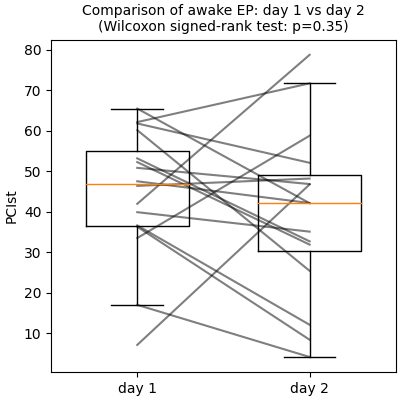

In [21]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)

ax.plot([0,1], [PCI_d1d2df['day1'].values, PCI_d1d2df['day2'].values], color='k', linewidth=1.5, alpha=0.5)
ax.boxplot([PCI_d1d2df['day1'].values, PCI_d1d2df['day2'].values], positions=[0, 1], widths=[0.6, 0.6], showfliers=False)
ax.set_ylabel('PCIst')
ax.set_xticks([0,1])
ax.set_xticklabels(['day 1', 'day 2'])
ax.set_title('Comparison of awake EP: day 1 vs day 2\n(Wilcoxon signed-rank test: p={:.2f})'.format(d1d2_stats['p-val'].values[0]));

## Save ##
figname = 'awakeEP_d1d2_PCI_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

### Across states

In [23]:
np.unique(EEG_metrics['experiment'].values)

array(['isoflurane', 'ketanserin', 'psilocybin', 'saline', 'urethane'],
      dtype=object)

In [24]:
## ORIGINAL ##
prepost = []
metric = 'echo' # 'PCIst', 'response_duration', 'late_amp', 'echo'
for expi in np.unique(EEG_metrics['experiment'].values):
    expdf = EEG_metrics[EEG_metrics['experiment'] == expi]
    for mousei in np.unique(expdf['mouse'].values):
        if expi == 'urethane':
            subdf = EEG_metrics[EEG_metrics['mouse'] == mousei]
            if len(np.unique(subdf['experiment'].values)) < 2:
                continue
            else:
                for slev in ['low', 'mid', 'high']:
                    urdf = expdf[(expdf['mouse'] == mousei) & (expdf['stim_current'] == slev) & (expdf['behavior'] == 'rest')]
                    awdf = subdf[(subdf['state'] == 'awake') & (subdf['stim_current'] == slev) & (subdf['behavior'] == 'rest')]
                    if (len(urdf) == 1) & (len(awdf) > 0):
                        prepost.append([mousei, expi, slev, 'rest', np.max(awdf[metric].values), urdf[metric].values[0]])
        else:
            for slev in ['low', 'mid', 'high']:
                for behi in behaviors.keys():
                    tdf = expdf[(expdf['mouse'] == mousei) & (expdf['stim_current'] == slev) & (expdf['behavior'] == behi)]
                    if len(tdf) == 2:
                        prepost.append([
                            mousei, expi, slev, behi, tdf[tdf['state'] == 'awake'][metric].values[0], tdf[tdf['state'] == expi][metric].values[0]
                        ])
prepostdf = pd.DataFrame(prepost, columns=['mouse', 'experiment', 'stim_current', 'behavior', 'pre', 'post'])
prepostdf.head()

,mouse,experiment,stim_current,behavior,pre,post
0,676726,isoflurane,mid,rest,0.330412,0.481190
1,676727,isoflurane,mid,rest,0.381541,0.188000
2,688277,isoflurane,low,rest,0.681964,1.047274
3,688277,isoflurane,mid,rest,0.224046,0.596837
4,688277,isoflurane,high,rest,0.392906,0.411408


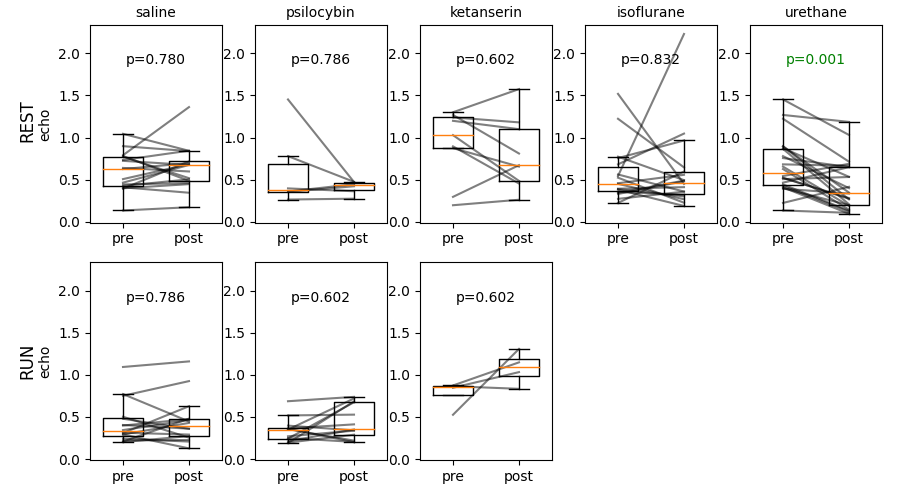

In [26]:
plot_exps = ['saline', 'psilocybin', 'ketanserin', 'isoflurane', 'urethane']

fig = plt.figure(figsize=(9,5))
gs = fig.add_gridspec(ncols=len(plot_exps), nrows=len(behaviors), left=0.1, right=0.98, top=0.95, bottom=0.08, hspace=0.2, wspace=0.25)

axlist = []
plist = []
for coli, expi in enumerate(plot_exps):
    for rowi, behi in enumerate(behaviors.keys()):
        plotdf = prepostdf[(prepostdf['experiment'] == expi) & (prepostdf['behavior'] == behi)]
        if len(plotdf) > 0:
            wstats = pg.wilcoxon(x=plotdf['pre'].values, y=plotdf['post'].values, alternative='two-sided')
            # print('{}-{}: p={:.3f}'.format(expi, behi, wstats['p-val'].values[0]))
            plist.append(wstats['p-val'].values[0])
            ax = fig.add_subplot(gs[rowi, coli])
            ax.plot([0,1], [plotdf['pre'].values, plotdf['post'].values], color='k', linewidth=1.5, alpha=0.5)
            ax.boxplot([plotdf['pre'].values, plotdf['post'].values], positions=[0, 1], widths=[0.6, 0.6], showfliers=False)
            axlist.append(ax)
            if coli == 0:
                ax.set_ylabel(metric)
            if rowi == 0:
                ax.set_title(expi)

## Correct p-values with Benjamini-Hochberg false discovery rate ##
corrpvals = pg.multicomp(plist, alpha=0.05, method='fdr_bh')

for ax in axlist[1:]:
    ax.sharex(axlist[0])
    ax.sharey(axlist[0])
ax.set_xticks([0,1])
ax.set_xticklabels(['pre', 'post'])

fig.text(0.02, 0.725, 'REST', fontsize=12, rotation='vertical')
fig.text(0.02, 0.25, 'RUN', fontsize=12, rotation='vertical')

for ax, pval in zip(axlist, corrpvals[1]):
    if pval < 0.05:
        tcolor = 'g'
    else:
        tcolor = 'k'
    ax.annotate('p={:.3f}'.format(pval), xy=(0.5, 2.0), ha='center', va='top', color=tcolor)

## Save ##
figname = 'allstatesEP_prepost_psi0-90_{}_{}.png'.format(metric, date.today().strftime('%b%d%Y'))
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

### Plot PCI change from pre-post

In [44]:
prepostdf['diff'] = prepostdf['post'] - prepostdf['pre']
prepostdf['percentchange'] = prepostdf['diff'] / prepostdf['pre']
prepostdf['category'] = prepostdf['experiment'] + prepostdf['behavior']
prepostdf.head()

,mouse,experiment,stim_current,behavior,pre,post,diff,percentchange,category
0,676726,isoflurane,mid,rest,22.819898,13.513059,-9.306838,-0.407839,isofluranerest
1,676727,isoflurane,mid,rest,18.172520,13.976769,-4.195752,-0.230884,isofluranerest
2,688277,isoflurane,low,rest,6.105180,4.060839,-2.044341,-0.334854,isofluranerest
3,688277,isoflurane,mid,rest,21.825865,6.387432,-15.438432,-0.707346,isofluranerest
4,688277,isoflurane,high,rest,34.590444,13.082002,-21.508441,-0.621803,isofluranerest


Plot the difference

Text(0.5, 1.0, 'EP metric change pre to post drug intervention')

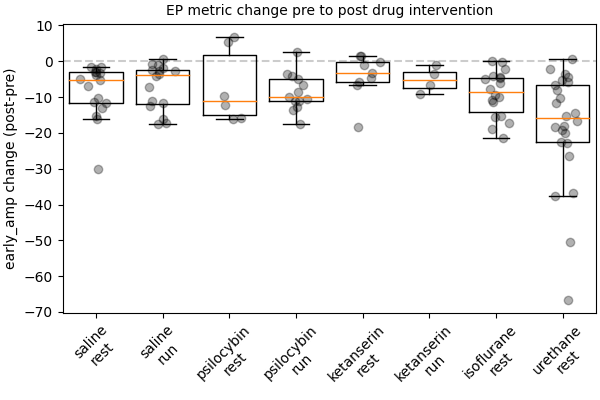

In [45]:
# plot_exps = ['saline', 'psilocybin', 'ketanserin', 'isoflurane', 'urethane']
plot_cats = {'saline': ['rest', 'run'], 'psilocybin': ['rest', 'run'], 'ketanserin': ['rest', 'run'], 'isoflurane': ['rest'], 'urethane': ['rest']}
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)

indi = 0
xts = []
xtls = []
ax.axhline(0, color='k', linestyle='dashed', alpha=0.2)
for expi, behlist in plot_cats.items():
    for behi in behlist:
        plotdf = prepostdf[(prepostdf['experiment'] == expi) & (prepostdf['behavior'] == behi)]
        if len(plotdf) > 0:
            xs = np.random.normal(indi, 0.1, len(plotdf)) # np.zeros(len(plotdf)) + indi
            ax.boxplot(
                plotdf['diff'].values, positions=[indi], widths=[0.8], showfliers=False,
                # medianprops={'color': st_colors[ii], 'linewidth': 2}, boxprops={'color': st_colors[ii]}
            )
            ax.scatter(xs, plotdf['diff'].values, c='k', marker='o', alpha=0.3)
            xts.append(indi)
            xtls.append(expi + '\n' + behi)
            indi += 1

ax.set_xticks(xts)
ax.set_xticklabels(xtls, rotation=45)
ax.set_ylabel('{} change (post-pre)'.format(metric))
ax.set_title('EP metric change pre to post drug intervention')

Plot as percent change

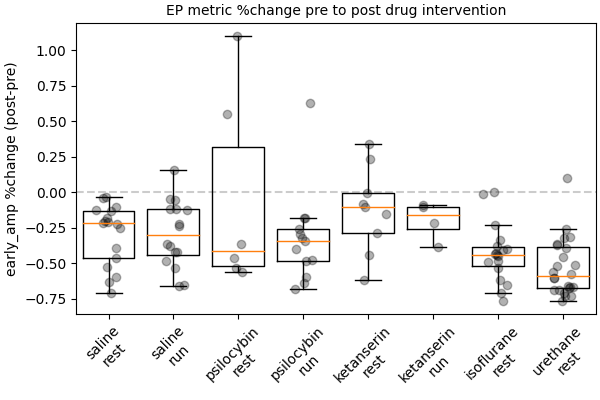

In [46]:
plot_cats = {'saline': ['rest', 'run'], 'psilocybin': ['rest', 'run'], 'ketanserin': ['rest', 'run'], 'isoflurane': ['rest'], 'urethane': ['rest']}
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)

indi = 0
xts = []
xtls = []
ax.axhline(0, color='k', linestyle='dashed', alpha=0.2)
for expi, behlist in plot_cats.items():
    for behi in behlist:
        plotdf = prepostdf[(prepostdf['experiment'] == expi) & (prepostdf['behavior'] == behi)]
        if len(plotdf) > 0:
            xs = np.random.normal(indi, 0.1, len(plotdf)) # np.zeros(len(plotdf)) + indi
            ax.boxplot(
                plotdf['percentchange'].values, positions=[indi], widths=[0.8], showfliers=False,
                # medianprops={'color': st_colors[ii], 'linewidth': 2}, boxprops={'color': st_colors[ii]}
            )
            ax.scatter(xs, plotdf['percentchange'].values, c='k', marker='o', alpha=0.3)
            xts.append(indi)
            xtls.append(expi + '\n' + behi)
            indi += 1

ax.set_xticks(xts)
ax.set_xticklabels(xtls, rotation=45)
ax.set_ylabel('{} %change (post-pre)'.format(metric))
ax.set_title('EP metric %change pre to post drug intervention')

## Save ##
figname = 'allstatesEP_psi0-90_{}_prepostpercentchange_{}.png'.format(metric, date.today().strftime('%b%d%Y'))
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

##### ANOVA

In [47]:
allstates_anova = pg.anova(data=prepostdf, dv='percentchange', between='category')

In [48]:
allstates_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,category,7,99,3.856488,0.000946,0.214257


post-hoc pairwise tests

In [26]:
ph_tukey = pg.pairwise_tukey(data=prepostdf, dv='percentchange', between='category')

In [27]:
ph_tukey[ph_tukey['p-tukey'] < 0.05]

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
17,ketanserinrun,urethanerest,0.242252,-0.657593,0.899845,0.213744,4.209929,0.001410,2.416782
24,psilocybinrun,urethanerest,-0.010351,-0.657593,0.647242,0.136293,4.748904,0.000182,1.388977
26,salinerest,urethanerest,-0.195871,-0.657593,0.461722,0.125462,3.680177,0.008747,1.602340
27,salinerun,urethanerest,-0.236933,-0.657593,0.420660,0.127736,3.293195,0.028788,1.286998


##### Non-parametric: Kruskal Wallis

In [49]:
allstates_kw = pg.kruskal(data=prepostdf, dv='percentchange', between='category')

In [50]:
allstates_kw

,Source,ddof1,H,p-unc
Kruskal,category,7,25.343936,0.000659


post-hoc pairwise tests

In [51]:
ph_np = pg.pairwise_tests(data=prepostdf, dv='percentchange', between='category', parametric=False)

In [52]:
ph_np[ph_np['p-unc'] < 0.05]

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges
0,category,isofluranerest,ketanserinrest,False,False,33.0,two-sided,0.014560,-1.243442
1,category,isofluranerest,ketanserinrun,False,False,11.0,two-sided,0.033083,-1.143321
12,category,ketanserinrest,urethanerest,False,False,189.0,two-sided,0.001138,1.708600
17,category,ketanserinrun,urethanerest,False,False,87.0,two-sided,0.006935,1.643056
21,category,psilocybinrest,urethanerest,False,False,111.0,two-sided,0.043788,1.356448
24,category,psilocybinrun,urethanerest,False,False,233.0,two-sided,0.014942,0.794926
26,category,salinerest,urethanerest,False,False,326.0,two-sided,0.001303,1.107224
27,category,salinerun,urethanerest,False,False,306.0,two-sided,0.001727,1.085472


### Make plots of all EPs in a ppt

In [27]:
expi = 'saline'
clevel = 'mid'
behi = 'rest'

subsdf = prepostdf[(prepostdf['experiment'] == expi) & (prepostdf['stim_current'] == clevel) & (prepostdf['behavior'] == behi)]
subsdf

,mouse,experiment,stim_current,behavior,pre,post
52,631037,saline,mid,rest,0.409624,0.345049
57,654182,saline,mid,rest,0.426260,0.503936
65,655956,saline,mid,rest,0.897806,0.839377
67,669117,saline,mid,rest,0.781250,0.485973
69,669118,saline,mid,rest,0.733818,0.844424
73,730911,saline,mid,rest,0.772124,0.517838
79,735049,saline,mid,rest,0.393369,0.717528


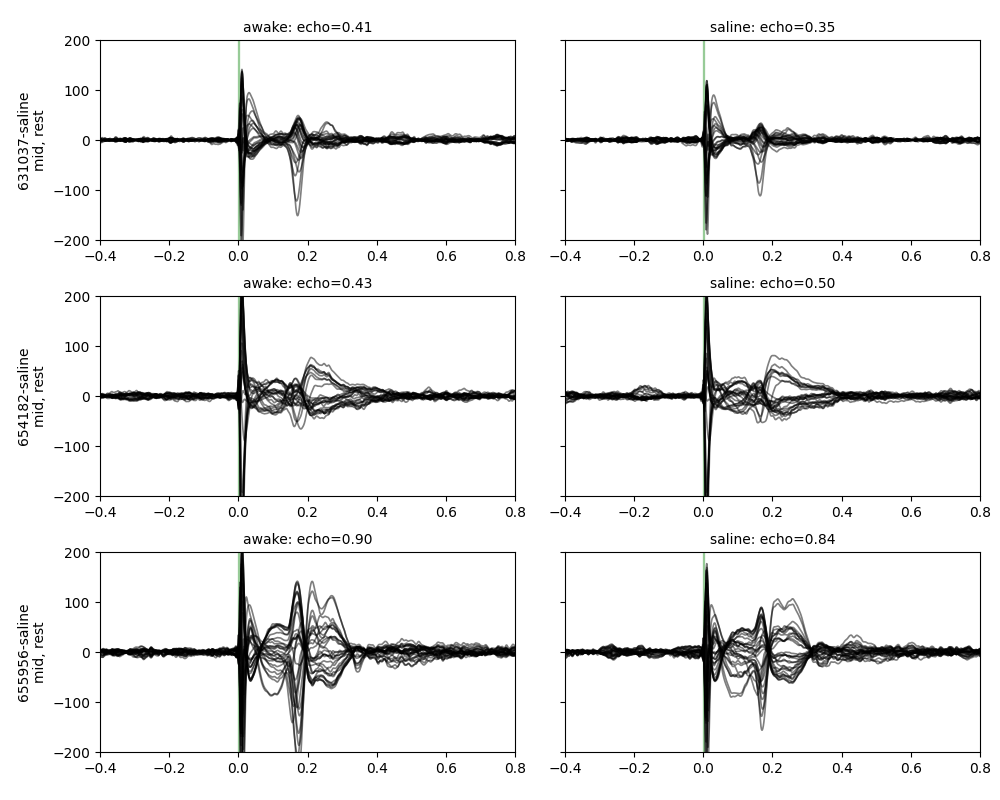

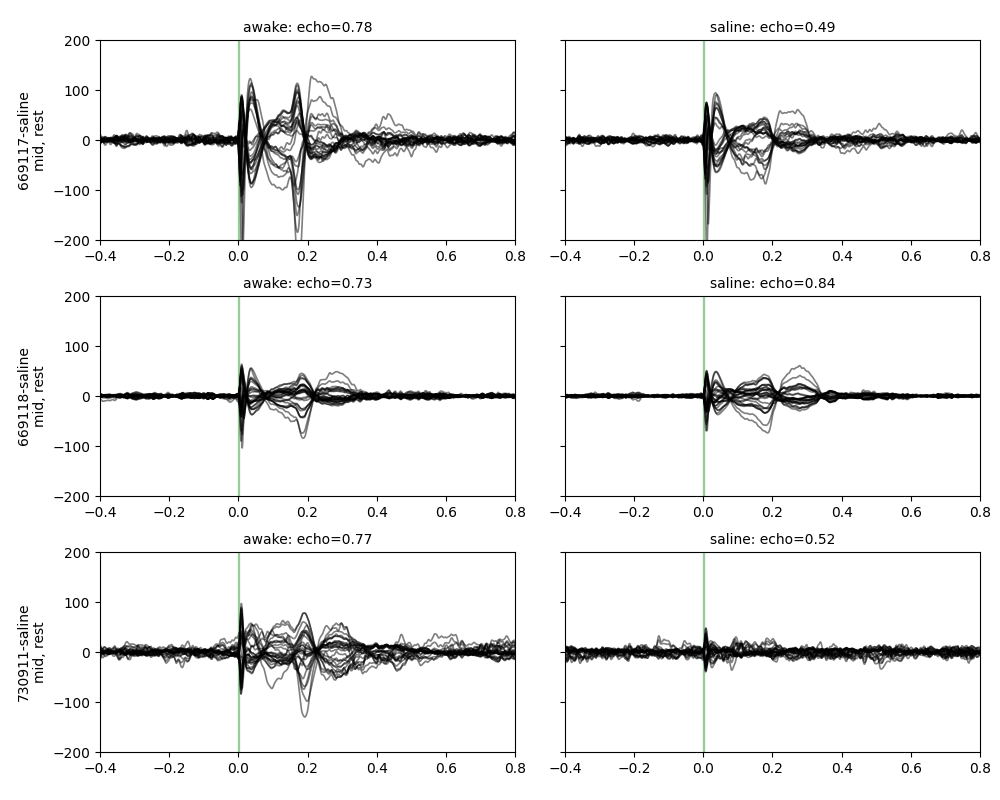

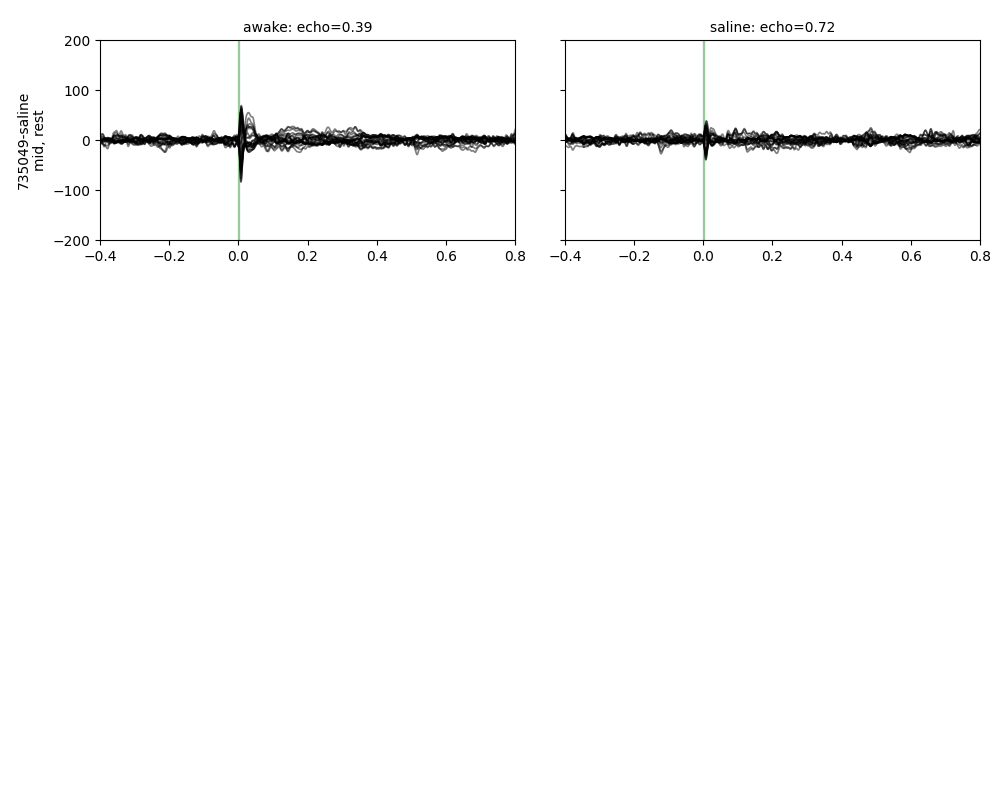

In [31]:
numr = 3
pmetric = 'echo' # 'PCIst'
for jj, smalldf in enumerate(np.split(subsdf, np.arange(0, len(subsdf), numr)[1:])):
    fig = plt.figure(figsize=(10,8))
    gs = fig.add_gridspec(ncols=1, nrows=numr, left=0.1, right=0.98, top=0.95, bottom=0.06, hspace=0.28)
    for ii, (pind, prow) in enumerate(smalldf.iterrows()):
        axs = gs[ii].subgridspec(nrows=1, ncols=2, wspace=0.12).subplots(sharex=True, sharey=True)
        if expi == 'urethane':
            loopstates = ['awake', 'urethane']
        else:
            loopstates = all_sub_traces[prow.mouse][prow.experiment][prow.stim_current][prow.behavior].keys()
        for ax, statei, pp in zip(axs, loopstates, ['pre', 'post']):
            if (expi == 'urethane') and (pp == 'pre'):
                awdf = EEG_metrics[
                    (EEG_metrics['mouse'] == prow.mouse) &
                    (EEG_metrics['stim_current'] == prow.stim_current) &
                    (EEG_metrics['behavior'] == prow.behavior) &
                    (EEG_metrics['state'] == 'awake')
                ]
                awmax = EEG_metrics.loc[awdf[pmetric].idxmax()]
                timex = all_sub_traces[awmax.mouse][awmax.experiment][awmax.stim_current][awmax.behavior][awmax.state][0]
                traces = all_sub_traces[awmax.mouse][awmax.experiment][awmax.stim_current][awmax.behavior][awmax.state][1]
            else:
                timex = all_sub_traces[prow.mouse][prow.experiment][prow.stim_current][prow.behavior][statei][0]
                traces = all_sub_traces[prow.mouse][prow.experiment][prow.stim_current][prow.behavior][statei][1]
            ax.axvspan(0, 0.002, color='g', alpha=0.3)
            ax.plot(timex, traces, color='k', linewidth=1.2, alpha=0.5)
            ax.set_title('{}: {}={:.2f}'.format(statei, pmetric, prow[pp]))
            
        ax.set_xlim([-0.4, 0.8])
        ax.set_ylim([-200, 200])
        axs[0].set_ylabel('{}-{}\n{}, {}'.format(prow.mouse, prow.experiment, prow.stim_current, prow.behavior))

##### Make the ppt

In [32]:
pmetric = 'echo' # 'PCIst'

In [33]:
## Create a new PowerPoint presentation to save figures to ##
prs = Presentation()
prs.slide_width = Inches(12)
prs.slide_height = Inches(8)

## Add title slide ##
slide = prs.slides.add_slide(prs.slide_layouts[0])
slide.shapes.title.text = f'EEG estim-EPs & echo measure across states'
slide.placeholders[1].text = 'Templeton experiments with estim\npre & post intervention\n{}'.format(date.today().strftime('%b %d, %Y'))

## Start the loop ##
for expi in plot_exps:
    expdf = prepostdf[prepostdf['experiment'] == expi]
    for clevel in ['low', 'mid', 'high']:
        for behi in behaviors.keys():
            subsdf = prepostdf[(prepostdf['experiment'] == expi) & (prepostdf['stim_current'] == clevel) & (prepostdf['behavior'] == behi)]
            for jj, smalldf in enumerate(np.split(subsdf, np.arange(0, len(subsdf), numr)[1:])):
                fig = plt.figure(figsize=(10,8))
                gs = fig.add_gridspec(ncols=1, nrows=numr, left=0.1, right=0.98, top=0.95, bottom=0.06, hspace=0.28)
                for ii, (pind, prow) in enumerate(smalldf.iterrows()):
                    axs = gs[ii].subgridspec(nrows=1, ncols=2, wspace=0.12).subplots(sharex=True, sharey=True)
                    if expi == 'urethane':
                        loopstates = ['awake', 'urethane']
                    else:
                        loopstates = all_sub_traces[prow.mouse][prow.experiment][prow.stim_current][prow.behavior].keys()
                    for ax, statei, pp in zip(axs, loopstates, ['pre', 'post']):
                        if (expi == 'urethane') and (pp == 'pre'):
                            awdf = EEG_metrics[
                                (EEG_metrics['mouse'] == prow.mouse) &
                                (EEG_metrics['stim_current'] == prow.stim_current) &
                                (EEG_metrics['behavior'] == prow.behavior) &
                                (EEG_metrics['state'] == 'awake')
                            ]
                            awmax = EEG_metrics.loc[awdf[pmetric].idxmax()]
                            timex = all_sub_traces[awmax.mouse][awmax.experiment][awmax.stim_current][awmax.behavior][awmax.state][0]
                            traces = all_sub_traces[awmax.mouse][awmax.experiment][awmax.stim_current][awmax.behavior][awmax.state][1]
                        else:
                            timex = all_sub_traces[prow.mouse][prow.experiment][prow.stim_current][prow.behavior][statei][0]
                            traces = all_sub_traces[prow.mouse][prow.experiment][prow.stim_current][prow.behavior][statei][1]
                        ax.axvspan(0, 0.002, color='g', alpha=0.3)
                        ax.plot(timex, traces, color='k', linewidth=1.2, alpha=0.5)
                        ax.set_title('{}: {}={:.2f}'.format(statei, pmetric, prow[pp]))
                        
                    ax.set_xlim([-0.4, 0.8])
                    ax.set_ylim([-200, 200])
                    axs[0].set_ylabel('{}-{}\n{}, {}'.format(prow.mouse, prow.experiment, prow.stim_current, prow.behavior))

                plt.close(fig)
                #### Add current figures to ppt ####
                save_fig_to_pptx(fig, prs)
## Save the ppt ##
prs.save(os.path.join(plotdir, 'All_estimEEGEP_prepost_{}_{}.pptx'.format(pmetric, date.today().strftime('%b%d%Y'))))

#### Plot EPs from example subjects

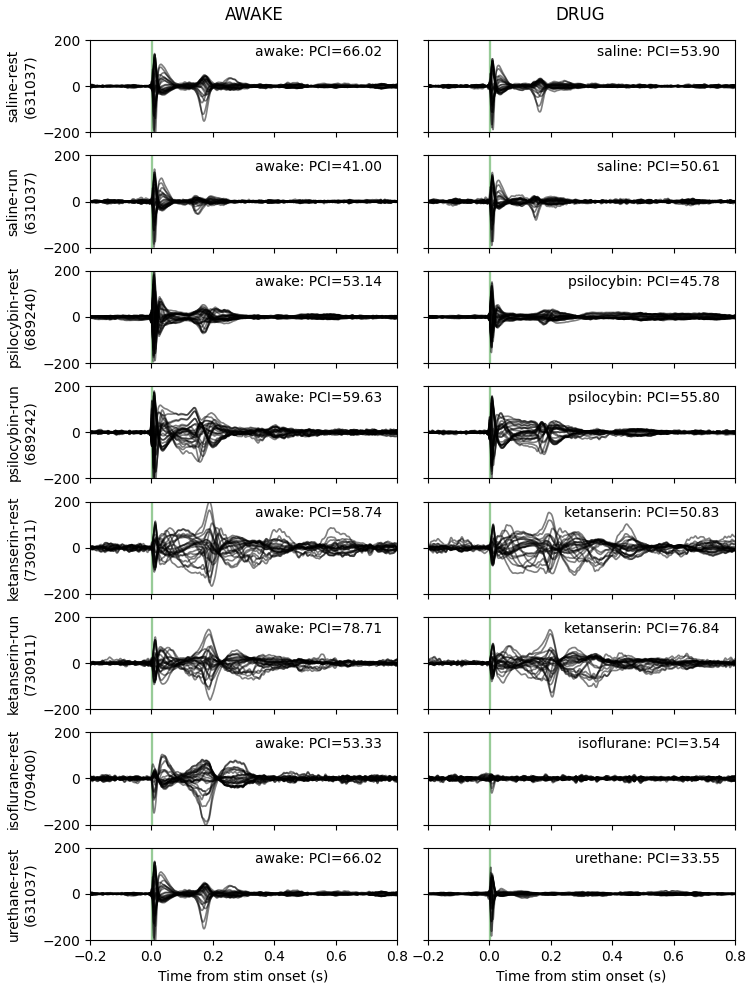

In [28]:
psub_inds = [41, 42, 29, 32, 16, 17, 11, 70]

fig = plt.figure(figsize=(7.5, 10))
gs = fig.add_gridspec(ncols=1, nrows=len(psub_inds), left=0.12, right=0.98, top=0.96, bottom=0.06, hspace=0.25)

for ii, subi in enumerate(psub_inds):
    prow = prepostdf.iloc[subi]
    axs = gs[ii].subgridspec(nrows=1, ncols=2, wspace=0.1).subplots(sharex=True, sharey=True)
    if prow.experiment == 'urethane':
        loopstates = ['awake', 'urethane']
    else:
        loopstates = all_sub_traces[prow.mouse][prow.experiment][prow.stim_current][prow.behavior].keys()
    for ax, statei, pp in zip(axs, loopstates, ['pre', 'post']):
        if (prow.experiment == 'urethane') and (pp == 'pre'):
            awdf = EEG_metrics[
                (EEG_metrics['mouse'] == prow.mouse) &
                (EEG_metrics['stim_current'] == prow.stim_current) &
                (EEG_metrics['behavior'] == prow.behavior) &
                (EEG_metrics['state'] == 'awake')
            ]
            awmax = EEG_metrics.loc[awdf['PCIst'].idxmax()]
            timex = all_sub_traces[awmax.mouse][awmax.experiment][awmax.stim_current][awmax.behavior][awmax.state][0]
            traces = all_sub_traces[awmax.mouse][awmax.experiment][awmax.stim_current][awmax.behavior][awmax.state][1]
        else:
            timex = all_sub_traces[prow.mouse][prow.experiment][prow.stim_current][prow.behavior][statei][0]
            traces = all_sub_traces[prow.mouse][prow.experiment][prow.stim_current][prow.behavior][statei][1]
        ax.axvspan(0, 0.002, color='g', alpha=0.3)
        ax.plot(timex, traces, color='k', linewidth=1.2, alpha=0.5)
        ax.annotate('{}: PCI={:.2f}'.format(statei, prow[pp]), xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top')
        if ii == len(psub_inds)-1:
            ax.set_xlabel('Time from stim onset (s)')
        else:
            ax.set_xticklabels([])
        
    ax.set_xlim([-0.2, 0.8])
    ax.set_ylim([-200, 200])
    axs[0].set_ylabel('{}-{}\n({})'.format(prow.experiment, prow.behavior, prow.mouse))

fig.text(0.3, 0.98, 'AWAKE', fontsize=12, rotation='horizontal')
fig.text(0.74, 0.98, 'DRUG', fontsize=12, rotation='horizontal')

## Save ##
figname = 'allstates_EPexamples_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)